In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

## 2.1 Introduction

This chapter introduces more PyMC syntax and design patterns, and ways to think about how to model a system from a Bayesian perspective. It also contains tips and data visualization techniques for assesing goodness of fit for your Bayesian model.

#### 2.1.1 Parent and Child Relationships

To assist with describing Bayesisan relationships and to be consistent with PyMC's documentation, we introduce _parent_ and _child_ variables.

* **Parent variables** are variables that influence another variable.
* **Child variables** are variables that are affected by other variables - that is, are the subject of parent variables.

A variable can be both a parent and child. For example, consider the following PyMC code:

In [2]:
import pymc as pm

lambda_ = pm.Exponential("poisson_param", 1)
# used in the call to the next variable ...
data_generator = pm.Poisson("data_generator", lambda_)

data_plus_one = data_generator + 1

```lambda_``` controls the parameter of ```data_generator```, hence influences its values. The former is a parent of the latter. By symmetry, ```data_generator``` is a child of ```lambda_```.

Likewise, ```data_generator``` is a parent to the variable ```data_plus_one``` (hence making ```data_generator``` both a parent and child variable). Although it does not look like one, ```data_plus_one``` should be treated as a PyMC variable as it is a _function_ of another PyMC variable, hence is a child variable to ```data_generator```

This nomentclature is introduced to help us describe relationships in PyMC modeling. You can access a variable's children and parent variables using the ```children``` and ```parents``` attributes attached to variables.



In [3]:
print "Children of 'lambda_': "
print lambda_.children
print "\n Parents of 'data_generator': "
print data_generator.parents
print "\n Children of 'data_generator': "
print data_generator.children

Children of 'lambda_': 
set([<pymc.distributions.Poisson 'data_generator' at 0x000000000C7F2240>])

 Parents of 'data_generator': 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x0000000008B965C0>}

 Children of 'data_generator': 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x0000000008B964A8>])


### 2.1.2 PyMC Variables

All PyMC variables expose a ```value``` property. This property produces the _current_ (possibly random) internal value of the variable. If the variable is a child variable, its value changes given the variable's parents' values.
Using the same variables from before:

In [4]:
print "lambda_.value = ", lambda_.value
print "data_generator.value = ", data_generator.value
print "data_plus_one.value = ", data_plus_one.value

lambda_.value =  0.714540440115
data_generator.value =  0
data_plus_one.value =  1


PyMC is concerned with two types of programming variables: ```Stochastic``` and ```deterministic```.

* **Stochastic variables** are variables that are not deterministic, i.e. even if you knew all the values of the variables' parents (if if even has any parents), it would still be random. Included in this category are instances of classes ```Poisson, DiscreteUniform```, and ```Exponential```.
* **Deterministic variables** are variables that are not random if the variables's parents are known. This might be confusing at first; a quick mental check is _if I knew all of the variale foo's parent variables' values, I could determine exactly what foo's value is._

### Initializing Stochastic Variables

The first argument in initializing a stochastic variable is a string that represents the name of the variable.
After that are additional arguments that are class-specific. Zum Beispeil:

In [5]:
some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)

where 0, 4 are the ```DiscreteUniform```-specific lower and upper bound on the random variable.

In [7]:
# pm.DiscreteUniform??

The name argument is used to retreive the posterior distribution later in the analysis, so it is best to use a descriptive name. Typically, I use the Python variable's name.

For multivariable problems, rather than creating a Python array of stochastic variables, setting the ```size``` keyword in the call to a ```Stochastic``` variable creates an array of (independent) stochastic variables. The array behaves like a NumPy array when used like one, and references to its ```value``` attribute return NumPy arrays.

The ```size``` argument also solves the annoying case wher eyou may have many variables
$\beta_i, i = 1, ... N$ you wish to model.
Instead of creating arbitrary names and variabels for each one, like:

```
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)
...
```

We can instead wrap them in a single variable:
```
betas = pm.Uniform("betas", 0, 1, size=N)
```

In [9]:
## pm.Uniform??

### Calling ```random()```

We can also call on a stochastic variable's ```random()``` method, which (given the parent values) will generate a new, random value.
We demonstrate this using the texting example from Chapter 1

In [11]:
lambda_1 = pm.Exponential("lambda_1", 1) # prior on first behavior
lambda_2 = pm.Exponential("lambda_2", 1) # prior on second behavior
tau = pm.DiscreteUniform("tau", lower=0, upper = 10) # prior on behavior change

In [14]:
print "Initialized values ... "
print "lambda_1.value: %.3f " % lambda_1.value
print "lambda_2.value: %.3f " % lambda_2.value
print "tau.value: %.3f " % tau.value

lambda_1.random(), lambda_2.random(), tau.random()

print "After calling random() on the variables ... "
print "lambda_1.value: %.3f " % lambda_1.value
print "lambda_2.value: %.3f " % lambda_2.value
print "tau.value: %.3f " % tau.value

Initialized values ... 
lambda_1.value: 0.465 
lambda_2.value: 0.998 
tau.value: 6.000 
After calling random() on the variables ... 
lambda_1.value: 0.042 
lambda_2.value: 0.440 
tau.value: 10.000 


The call to ```random``` stores a new value into the variable's ```value``` attribute.

### Determistic Variables

Since most variables you will be modeling are stochastic, we distinguish variables with a 
```pymc.deterministic``` wrapper. (If you are unfamiliar with Python wrappers - also called _decorators_ - that's no problem. Just prepend the ```pymc.deterministic``` decorator before the variable declaration and you're good to go.) The declaration of a deterministic variable uses a Python function:

```
@pm.deterministic
def some_deterministic_var(v1=v1,):
    # jelly goes here.
```


For all purposes, we treat the object ```some deterministic var``` as a variable and not a Python function.

Prepending with the wrapper is the easiest way, but not the only way, to create deterministic variables. Elementary operations, like addition, exponentials, and so forth implicitly create deterministic variables. Zum Beispeil, the following returns a deterministic variable:

```
type(lambda_1 + lambda_2)
```

In [15]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [16]:
import numpy as np
n_data_points = 5

@pm.deterministic
def lambda_(tau = tau, lambda_1=lambda_1,lambda_2 =lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely; hence, it is a 
deterministic variable.

Inside the deterministic decorator, the ```Stochastic``` variables passed in behave like scalars or NumPy arrays (if multivariable), and _not_ like ```Stochastic``` variables. For example:

```
@pm.deterministic
def some_deterministic(stoch=some_stochastic_var):
    return stoch.value**2
```

will return an ```AttributeError``` detailing that ```stoch``` does not have a ```value``` attribute.
It simply needs to be ```stoch**2```.
During the learning phase, it's the variable's ```value``` that is repeatedly passed in, not the actual stochastic variable.

Notice that in the creation of the deterministic function that we use keyword arguments for each variable used in the function. This is a necessary step, and all variables _must_ be specified with keyword arguments.

### Including Observations in the Model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like, "What does my prior distribution of $\lambda_1$ look like?", as demonstrated below:

(0, 10)

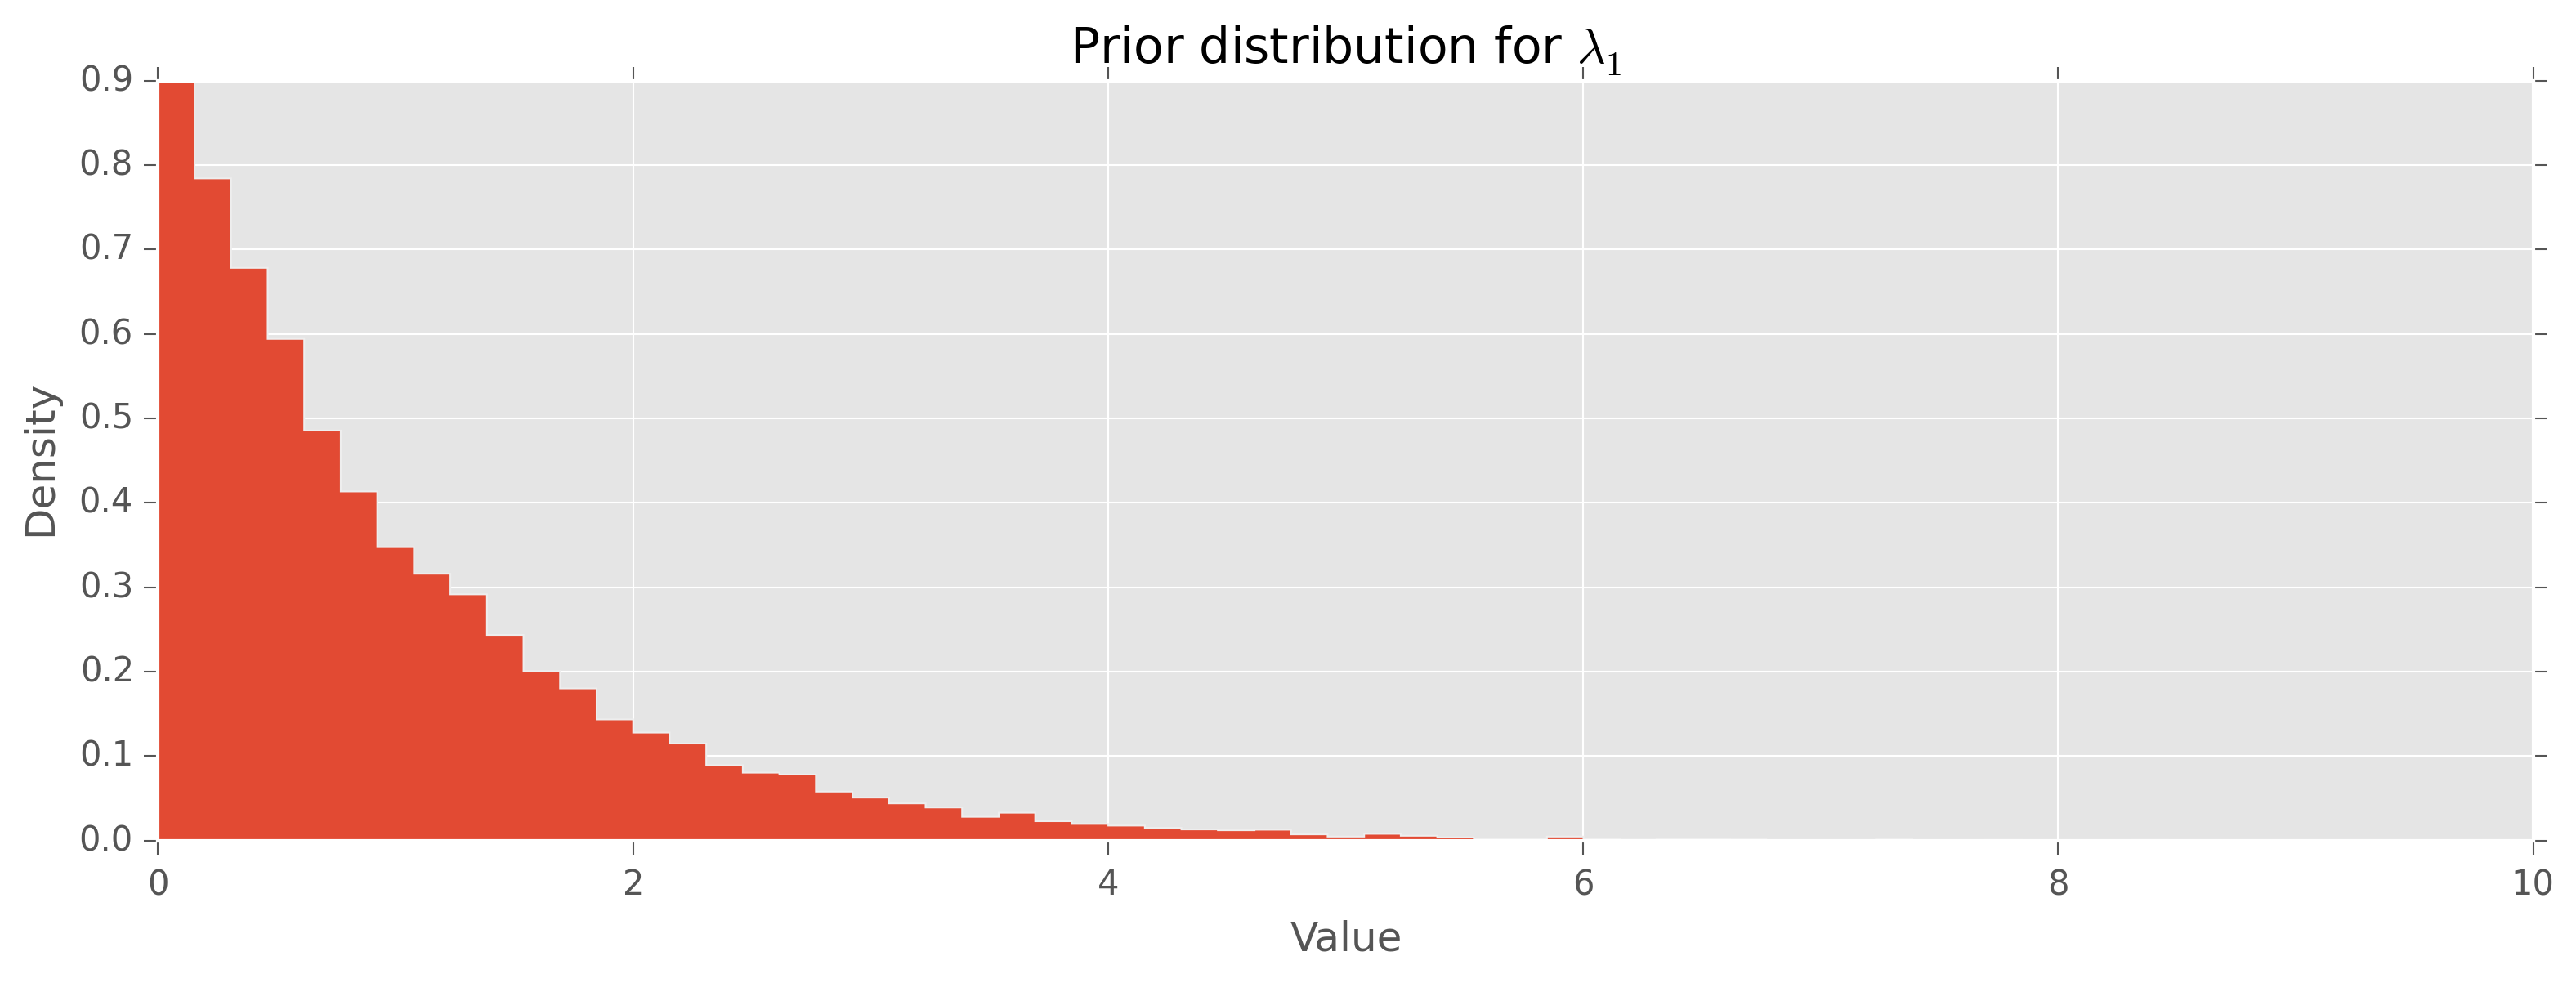

In [19]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as ploot
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
samples = [lambda_1.random() for i in range(20000)]

plt.hist(samples, bins=70, normed=True,histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0,10)